In [1]:
import cv2 as cv
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
#extracting image
cap = cv.VideoCapture("C:\\Users\\hp\\Desktop\\Level 3.mp4") #creating a video capture object
isTrue, frame = cap.read() #isTrue is a boolean value, which returns True is the frame is read 
# and stored in frame variable properly or not
print(frame.shape) #getting aware of the image dimension
cv.imwrite("extracted.png", frame) #saving the image as a png file in the working directory

(720, 1280, 3)


True

(720, 1280, 3)

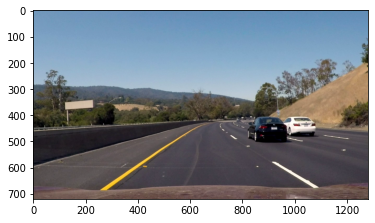

In [3]:
plotimgb = mpimg.imread('extracted.png') #storing as matplotlib image in a variable
plt.imshow(plotimgb) # note that our image plots in the 4th quadrant
#and y axis is inverted
plotimgb.shape

In [4]:
def place_lane(img): #this function places a translucent mask over the approximate region
    #it is a backup function
    
    mask = np.zeros_like(img) # places zeros with same dimensions as 
    # the image matrix, basically creating a black image [0 stands for black].
    
    #now we specify the 4 coordinates of our interest region quadrilateral
    #unlike level 1 and level 2, here we dont specify the exact coordinates by looking at the image plot
    #we try to generalize in terms of only image frame size 
    #so that this car can detect lanes even if the frame size changes
    #the coeeficients we find out by using calculator  
    coordinates = np.array([[(img.shape[1]*0.155,img.shape[0]),(img.shape[1]*0.45,img.shape[0]*0.63),
                             (img.shape[1]*0.56,img.shape[0]*0.6),(img.shape[1]*0.94,img.shape[0])]],np.int32)
    
    #this function fills green colour on the coordinates
    cv.fillPoly(mask,coordinates,(0,255,0)) 
    #                             |  |  |
    #                             |  |  |
    #                             V  V  V
    #                             B  G  R
    #                          (low)(high)(low) 
    
    masked_img = cv.bitwise_or(img,mask) #lane placed on apt position using OR Gate
    
    return masked_img

In [7]:
def crop_lane(img): #this function crops our interest area
    #exactly same as previous function  just AND Gate instead of OR Gate
    mask = np.zeros_like(img)
    coordinates = np.array([[(img.shape[1]*0.155,img.shape[0]),(img.shape[1]*0.45,img.shape[0]*0.63),
                             (img.shape[1]*0.56,img.shape[0]*0.63),(img.shape[1]*0.94,img.shape[0])]],np.int32)
    cv.fillPoly(mask,coordinates,(255,0,0)) # blue color though... still doesnt matter as it is just used as mask
    masked_img = cv.bitwise_and(img,mask) #AND operator instead of OR
    return masked_img

In [10]:
def make_mask(img,houghLines): #this function makes the mask and places it based on the given houghlines
    mask = np.zeros_like(img)# places zeros with same dimensions as 
    # the image matrix, basically creating a black image [0 stands for black].
    
    left_line_x = [] # stores list of X coordinates of the left lane
    left_line_y = [] # stores list of Y coordinates of the left lane
    right_line_x = [] # stores list of X coordinates of the right lane
    right_line_y = [] # stores list of Y coordinates of the right lane
    try:
        for line in houghLines:
            for x1, y1, x2, y2 in line: #this is order of variables in houghLines
                slope = (y2 - y1) / (x2 - x1) # Calculating the slope.
                if math.fabs(slope) < 0.55: # Only consider extreme slope
                    #this takes care of other extra lines in the road
                    continue
                if slope <= 0: #If the slope is negative, left group.
                    left_line_x.extend([x1, x2])
                    left_line_y.extend([y1, y2])
                else: #Otherwise, right group.
                    right_line_x.extend([x1, x2])
                    right_line_y.extend([y1, y2])
    except TypeError: #Houghlines maybe empty for some frames cases, ignore such cases
        pass
    if(len(left_line_x)!=0 and len(left_line_y)!=0 and len(right_line_x)!=0 and len(right_line_x)!=0) :
        #this if condition makes sure none of the lists are empty for some exceptional frames
        
        # by visualization from matplotlib graph, we set the coordinates of the highlighted portion 
        # of the lane
        x1 = min(left_line_x)
        y1 = max(left_line_y)
        x2 = max(left_line_x)
        y2 = min(left_line_y)
        x3 = min(right_line_x)
        y3 = min(right_line_y)
        # fixing last coordinate by seeing the plot
        # to achieve stability, its a bias term basically
        x4 = 1190
        y4 = 720
        
        #now placing the detected coordinates and creating mask and
        #performing Bitwise OR same as explained in the place lane function
        coordinates = np.array([[(x1,y1),(x2,y2),(x3,y3),(x4,y4)]],np.int32)
        cv.fillPoly(mask,coordinates,(0,255,0))
        masked_img = cv.bitwise_or(img,mask)
    else:
        #by any chance, if the any of the lists is empty
        #skip error by placing an approximate value of lane...
        #though this will occur rarely, still has the potential to crash the Jupyter kernel 
        # hence taken care of
        masked_img = place_lane(img)
    return masked_img

In [14]:
cap = cv.VideoCapture("C:\\Users\\hp\\Desktop\\Level 3.mp4") #capture the video frame wise
output = cv.VideoWriter("_MITvideo_vid3.mp4",cv.VideoWriter_fourcc('M', 'P', '4', 'V'), 30, (1280, 720))
# first argument is name of file to be saved
# second argument is four character codec and format specifier
# third argument is frames per second
# fourth argument is (width,height)
while True: #loop for every frame
    isTrue, frame = cap.read()
    if not isTrue: #escape if any case a null frame is detected
        cv.destroyAllWindows() #closes window if opened
        break
    # cv.cvtColor(frame,cv.COLOR_BGR2GRAY) --> this statment is adviced to not to write 
    # for multicolor lanes like yellow and white , edge detection wont be able to detect 
    kernel = 5 #kernel size for guassian blur
    blur = cv.GaussianBlur(frame,(kernel,kernel),0) # 3rd argument is standard deviation, 
    # see documentation for mathematics of guassian blur
    canny = cv.Canny(blur,50,150) # edge detected
    # see documentation for mathematics of canny edge detection
    cropped = crop_lane(canny) # interest area is cropped
    
    houghLines = cv.HoughLinesP(cropped,rho=6,theta=np.pi / 60,threshold=160,lines=np.array([]),minLineLength=40,maxLineGap=25)
    # straightlines detected using Houghlines, see documentation for mathematics and parameters
    
    lined_img = make_mask(frame,houghLines) #makes and places the mask
    
    output.write(lined_img) #using video writer object, write the modified frame in a variable
    
    cv.imshow('New',lined_img) #display the frame
    
    if cv.waitKey(20)==ord('q'): 
        # 20 miliseconds specified in between each frame
        cv.destroyAllWindows()
        break # break the loop is key q is pressed from keyboard or end of iterations reached

hello1
hello1
hello1
hello2
hello2
hello2
hello2
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello2
hello2
hello2
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello2
hello2
hello2
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello2
hello2
hello2
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello2
hello2
hello2
hello1
hello1
hello2
hello1
hello1
hello1
hello1
hello1
hello1
hello2
hello2
hello2
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello2
hello2
hello2
hello2
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello2
hello2
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello2
hello2
hello2
hello2
hello2
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello2
hello2
hello2
hello2
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello2
hello2
hello2
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello1
hello2
hello1
hello1
hello1
hello1
hello1
hello1